In [89]:
import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset
import pandas as pd

## Dataset

In [90]:
import pickle
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
import torch.nn.functional as F

class MyDataset(VisionDataset):
    def __init__(
        self,
        root: str = ".",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
        normalize: Tuple[float, float] = None,
    ) -> None:
        super().__init__(root, transform=transform, target_transform=target_transform)

        self.labels = [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
        self.ids, self.data, self.features = self._load_data(root, ij=normalize)

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # id, img, features = self.ids[index], self.data[index], self.features.iloc[index]
        img, features = torch.tensor(self.data[index]), torch.tensor(self.features.iloc[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        # img = Image.fromarray(img.numpy().astype(np.uint8))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, features

    def __len__(self) -> int:
        return len(self.data)
    
    def _load_data(self, root: str, ij: Tuple[float, float]):
        ids = pd.read_csv(f'{root}/PD_ids_train.csv')
        data = pd.read_csv(f'{root}/PD_imgs_np_train.csv')
        features = pd.read_csv(f'{root}/PD_conditions_train.csv')

        # convert all to list
        # TODO something better than a list
        ids = ids.values.tolist()
        data = data.values.tolist()
        features = features.values.tolist()

        # resize the data now
        # TODO hmmmm
        data = torch.tensor(data)
        # TODO the first byte is bad
        # remove the first column
        data = data[:, 1:]
        data = data.reshape(len(data), 140, 39).float()
        data = 2 * (data / 255) - 1

        data = F.interpolate(data.unsqueeze(1), size=(128, 39), mode='nearest').squeeze(1)
        data = data.reshape(len(data), -1)

        # TODO convert features to dtype f32 for mps
        features = pd.DataFrame(features, columns=self.labels).astype('float32')

        if ij is not None:
            # NOTE: (-1, 1) => y = 2 * (x - min) / (max - min) - 1
            #       ( i, j) => y = (j-i) * (x - min) / (max - min) + i
            features = (ij[1] - ij[0]) * (features - features.min()) / (features.max() - features.min()) + ij[0]
            # NOTE: they are nan because the min and max are the same, std is 0 (and mean is normally NaN); so we can just set them to 0
            features = features.fillna(0)

        return ids, data, features

### Why the Fancy Normalization Magic

In [91]:
dataset = MyDataset(root='data')

In [92]:
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

,index,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,count,668.000000,668.000000,668.000000,668.0,668.0,668.000000,668.000000,668.000000,668.000000,668.000000,6.680000e+02
1,mean,333.500000,68.757782,38.844311,0.0,0.0,327.544922,25.612276,5.974551,1456.746948,12.199998,3.087504e+05
2,std,192.979279,52.810501,61.393608,0.0,0.0,61.626793,3.267343,2.021091,20.019705,0.000000,0.000000e+00
3,min,0.000000,0.000000,0.000000,0.0,0.0,300.000000,21.000000,3.000000,1410.000000,12.200000,3.087504e+05
4,max,667.000000,200.000000,200.000000,0.0,0.0,500.000000,30.000000,9.000000,1485.000000,12.200000,3.087504e+05
5,sum,222778.000000,45930.199219,25948.000000,0.0,0.0,218800.000000,17109.000000,3991.000000,973106.937500,8149.598633,2.062453e+08


In [93]:
# normalize each column
df_normalized = (dataset.features - dataset.features.mean()) / dataset.features.std()
display(df_normalized)

# make the values between -1 and 1
df_normalized = (dataset.features - dataset.features.mean()) / dataset.features.std()
df_normalized = 2 * (df_normalized - df_normalized.min()) / (df_normalized.max() - df_normalized.min()) - 1
display(df_normalized)

,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,-1.728165,1.538372,-0.632709,NaN,NaN,2.798378,-0.493452,1.002156,0.152505,inf,NaN
1,-1.722983,0.970304,-0.632709,NaN,NaN,2.798378,1.342903,-1.471755,0.152505,inf,NaN
2,-1.717801,-1.301972,0.507474,NaN,NaN,-0.446963,0.424725,-0.482190,0.152505,inf,NaN
3,-1.712619,-1.301972,1.810542,NaN,NaN,-0.446963,1.342903,1.496939,0.152505,inf,NaN
4,-1.707437,1.538372,-0.632709,NaN,NaN,-0.446963,1.342903,0.012592,0.152505,inf,NaN
...,...,...,...,...,...,...,...,...,...,...,...
663,1.707437,-0.584311,-0.632709,NaN,NaN,2.798378,0.424725,-0.482190,0.152505,inf,NaN
664,1.712619,-0.923259,-0.144059,NaN,NaN,-0.446963,-1.411629,0.012592,0.152505,inf,NaN
665,1.717801,-0.582418,-0.632709,NaN,NaN,-0.446963,0.424725,-0.976973,-2.335047,inf,NaN
666,1.722983,0.591591,1.810542,NaN,NaN,-0.446963,1.342903,1.002156,0.152505,inf,NaN


,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,-1.000000,0.500,-1.0,NaN,NaN,1.0,-0.333333,0.666667,0.328001,NaN,NaN
1,-0.997001,0.200,-1.0,NaN,NaN,1.0,1.000000,-1.000000,0.328001,NaN,NaN
2,-0.994003,-1.000,-0.3,NaN,NaN,-1.0,0.333333,-0.333333,0.328001,NaN,NaN
3,-0.991004,-1.000,0.5,NaN,NaN,-1.0,1.000000,1.000000,0.328001,NaN,NaN
4,-0.988006,0.500,-1.0,NaN,NaN,-1.0,1.000000,0.000000,0.328001,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
663,0.988006,-0.621,-1.0,NaN,NaN,1.0,0.333333,-0.333333,0.328001,NaN,NaN
664,0.991005,-0.800,-0.7,NaN,NaN,-1.0,-1.000000,0.000000,0.328001,NaN,NaN
665,0.994003,-0.620,-1.0,NaN,NaN,-1.0,0.333333,-0.666667,-1.000000,NaN,NaN
666,0.997001,0.000,0.5,NaN,NaN,-1.0,1.000000,0.666667,0.328001,NaN,NaN


### Viewing the Data


data: tensor([1., 1., 1.,  ..., 1., 1., 1.])
features: tensor([-1.0000,  0.5000, -1.0000,  0.0000,  0.0000,  1.0000, -0.3333,  0.6667,
         0.3280,  0.0000,  0.0000])



/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_18368/4150976345.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img, features = torch.tensor(self.data[index]), torch.tensor(self.features.iloc[index])


,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,-1.0,0.5,-1.0,0.0,0.0,1.0,-0.333333,0.666667,0.328001,0.0,0.0


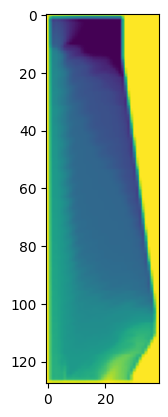

In [94]:
dataset = MyDataset(root='data', normalize=(-1, 1))
datum = dataset[0]
print(f"""
data: {datum[0]}
features: {datum[1]}
""")

# convert data to image plot
# TODO first pixel is bad
img = np.array(datum[0])
img = img.reshape(128, 39)
plt.imshow(img)

# convert features to dataframe
# TODO not correct, but ai guessed the labels, so its funny
# Ng = Nitrogen, Pci = Pesticide, H = Humidity, Wp = Watering pattern, Ph = pH, 0x = 0x, 0w = 0w, Hbt = Habitat, Wm = Weed management, Wr = Weather
labels = [ 'tg', 'Ng', 'Pci', 'H', 'Wp', 'Ph', 'Ox', 'Ow', 'Hbt', 'Wm', 'Wr' ]
conditions = np.array(datum[1])
features = pd.DataFrame([conditions], columns=labels)
display(features)

In [60]:
# get the count, mean, std, min, max, and sum of each column
df_aggregated = dataset.features.agg(['count', 'mean', 'std', 'min', 'max', 'sum']).reset_index()
display(df_aggregated)

,index,tg,Ng,Pci,H,Wp,Ph,Ox,Ow,Hbt,Wm,Wr
0,count,6.680000e+02,668.000000,668.000000,668.0,668.0,668.000000,668.000000,668.000000,668.000000,668.0,668.0
1,mean,-2.284250e-08,-0.312422,-0.611557,0.0,0.0,-0.724551,0.024950,-0.008483,0.246588,0.0,0.0
2,std,5.786485e-01,0.528105,0.613936,0.0,0.0,0.616268,0.726076,0.673697,0.533859,0.0,0.0
3,min,-1.000000e+00,-1.000000,-1.000000,0.0,0.0,-1.000000,-1.000000,-1.000000,-1.000000,0.0,0.0
4,max,1.000000e+00,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0
5,sum,-1.525879e-05,-208.697998,-408.519989,0.0,0.0,-484.000000,16.666679,-5.666660,164.720627,0.0,0.0


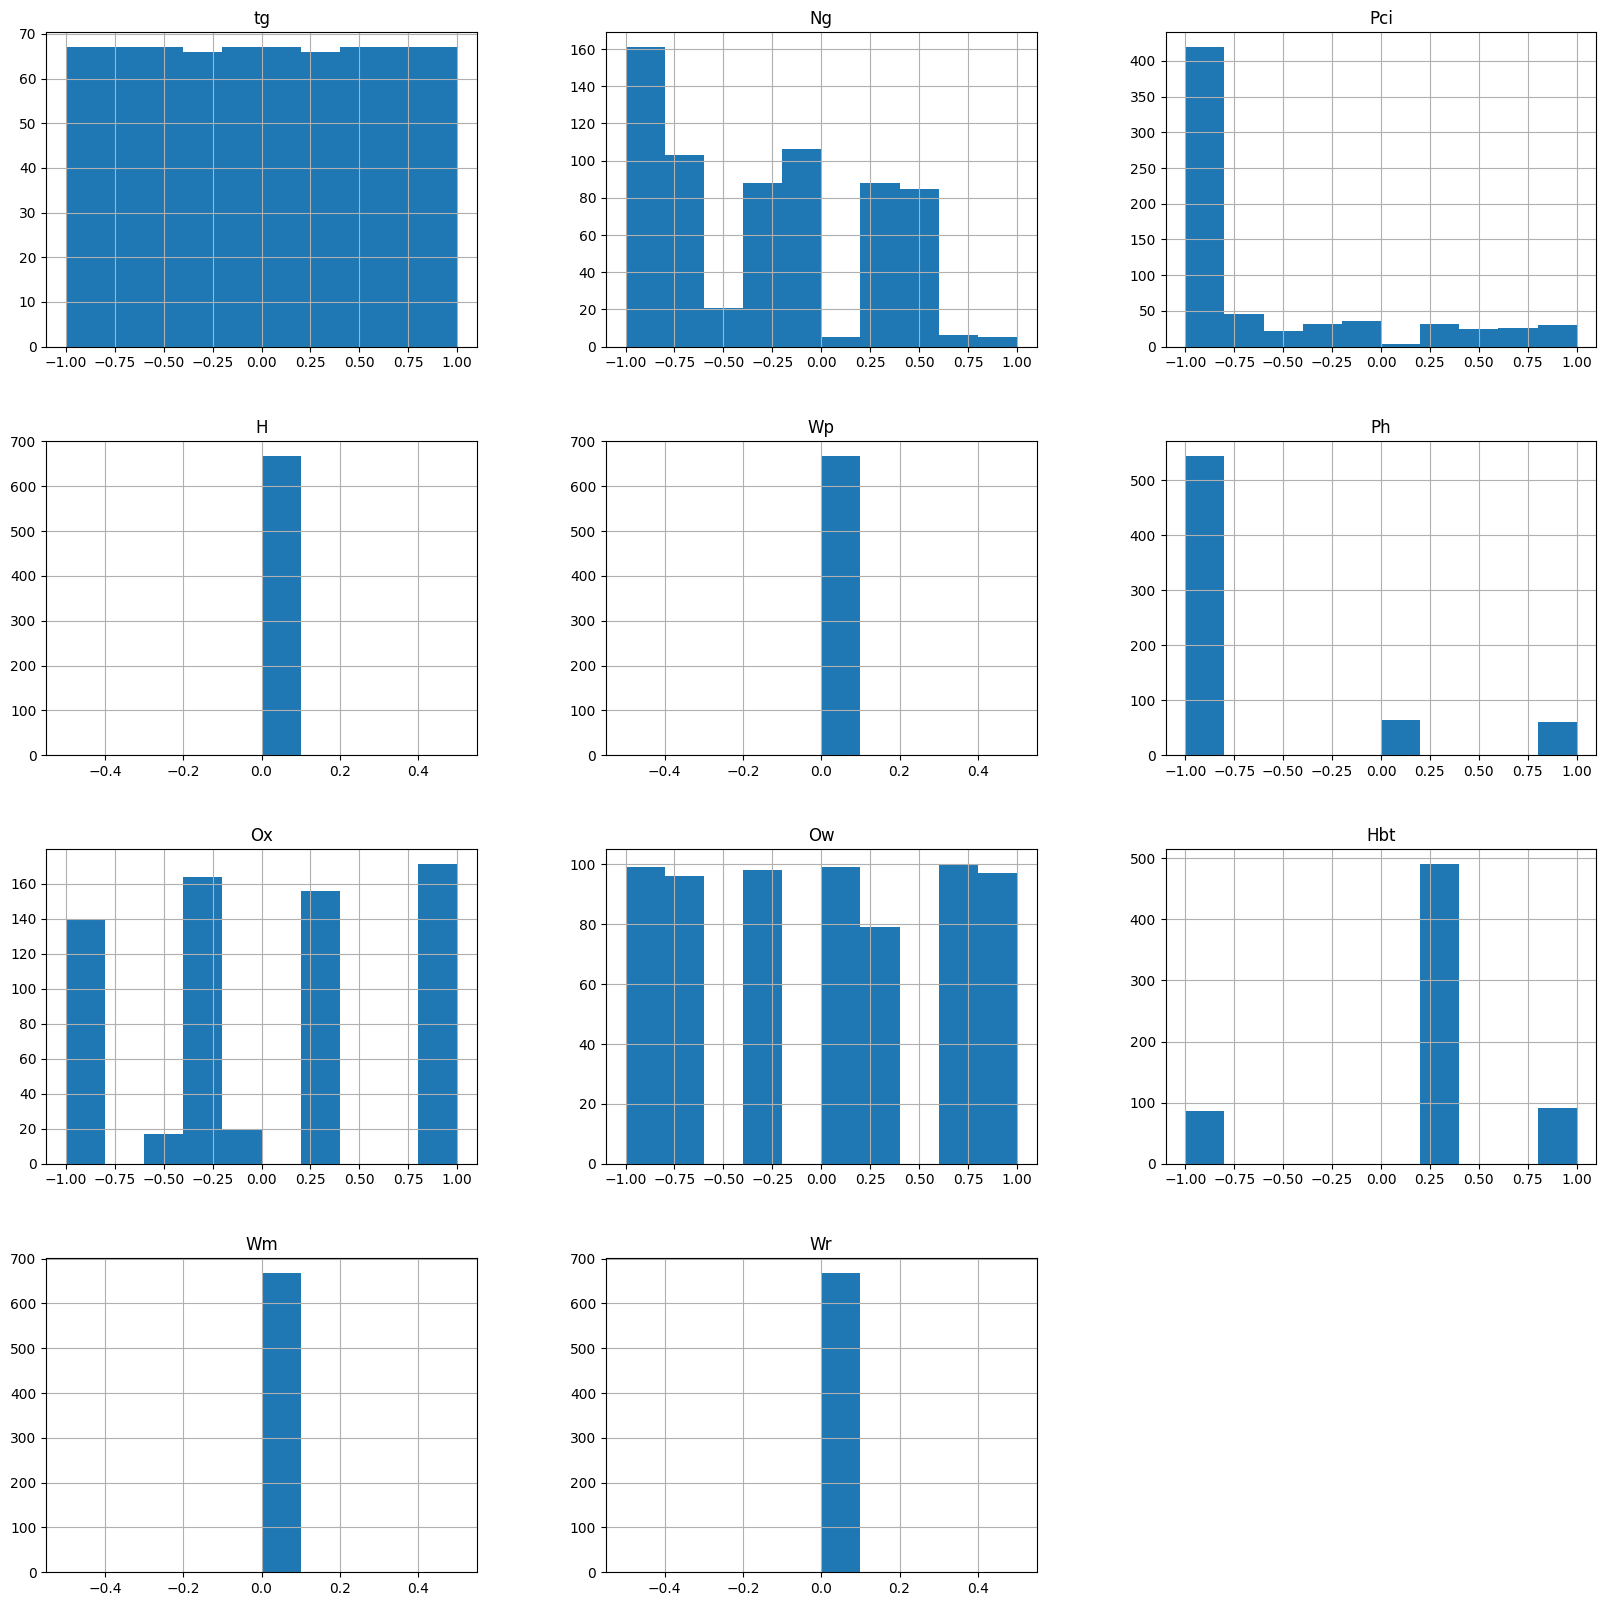

In [61]:
# create a histogram of each column
dataset.features.hist(figsize=(20, 20))
plt.show()

In [62]:
# get the memory usage so far
print(f"Memory usage: {dataset.features.memory_usage().sum()} bytes")

Memory usage: 29520 bytes


## CGAN

In [63]:

import torch
import numpy as np
import os

from torchvision import datasets
from torchvision import transforms
import torchvision.transforms as T

import matplotlib.pyplot as plt
import pandas as pd

from numpy import genfromtxt

from PIL import Image

import random

# import visiondataset
from torchvision.datasets import VisionDataset

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [65]:

from torch.utils.data import TensorDataset, DataLoader

import torch.optim as optim 
import torch.nn as nn


import torch.nn.functional as F

from torch.autograd import Variable

from fastai.vision.all import *
from fastai.vision.gan import *

from fastai.callback.all import *

In [66]:
from datasets import load_dataset, Split

In [67]:
import torch.autograd as autograd

In [68]:
channels = 1 ## 1 for B&W, 3 for RGB, 4 for RGBA

learning_rate    = 2e-4#0.003  ## Adam default   ## 0.001 2e-4#
batch_size       = 64
N_Epochs         = 10#4_000  ##27000  
num_classes = 1
width = 39
height = 140
img_size = width*height*channels
certainty_repeater = 6# channels**2 - num_classes
print(f"{img_size=}")

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps is not None:
    device = torch.device('mps')
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
else:
    device = torch.device('cpu')
    # print a warning that cpu is being used
    print("Warning: Running on CPU. This will be slow.")
print(f"{device=}")

img_size=5460
device=device(type='mps')


In [69]:
# convert the dataset into a train / test split
# TODO i dont think test is used
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.95, 0.05])

# define the dataloader
dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [70]:

def plot_GAN_losses(list_losses_fake):
    
    the_epochs = [i for i in range(len(list_losses_fake))]  

    plt.plot(the_epochs, list_losses_fake,    label = "fake") 
    plt.legend() 
    plt.show()


In [71]:

def print_metrics_function(y_test, y_pred):
    print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print("Confusion Matrix:")
    print(confmat)
    print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='weighted'))
    f1_measure = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    print('F1-mesure: %.3f' % f1_measure)
    return f1_measure, confmat


In [72]:
def plot_metric_per_epoch(the_scores_list):
    x_epochs = []
    y_epochs = [] 
    for i, val in enumerate(the_scores_list):
        x_epochs.append(i)
        y_epochs.append(val)
    
    plt.scatter(x_epochs, y_epochs,s=50,c='lightgreen', marker='s', label='score')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Score per epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [73]:
def random_G_vector_input():
    rand_vec = torch.randn( 100 ).to(device)
    return rand_vec

In [74]:
def random_G_batch_vector_input():
    rand_vec = torch.randn( (batch_size, 100 ) ).to(device)
    return rand_vec

In [75]:
def random_batch_one_hot_rc(batch_size, size):
    rand_vec = torch.zeros( (batch_size, num_classes ) ).to(device)
    for i in range(batch_size):
        random_idx = random.randint(0,size-1)
        rand_vec[i, random_idx] = 1.0
    return rand_vec

In [76]:
list_losses_real    = []
list_losses_fake    = []
list_losses_tricked = []

import tqdm

def training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt   ):
    pbar = tqdm.tqdm(range(N_Epochs+1))

    for epoch in pbar:
        # shuffle dl_train every epoch
        dl_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for xb, yb in dl_train:              ## xb = [batch, 1, 28, 28]
            xb, yb = xb.to(device), yb.to(device)
            # print the memory usage of mps

            if xb.shape[0] != batch_size:
                # print(f"skipping batch of size {xb.shape[0]}")
                continue

            xb = xb.reshape(batch_size, 128, width)
            xb = F.pad(xb, (0, 128-width, 0, 0), value=0)
            xb = torch.unsqueeze(xb, dim=1)
            # pad the image to 140x140
            # convert nb [batch, 384] to [batch, -1, 32, channels]

            yb_certainty = yb.repeat(channels, 128, 1, 1).permute(2, 0, 1, 3)#1, 0, 2) # [ batch, x (classes), y, channels ]
            # yb_certainty = nb.reshape(batch_size, channels, pixels, -1)
            real = torch.cat( (xb, yb_certainty) , dim=3)

            # print the real image TODO this will print nothing because it is normalized to highest number
            # plt.imshow(real[0].squeeze(0).cpu().detach().numpy())

            for _ in range(5):
                noise = torch.cat( (random_G_batch_vector_input(), yb) , dim=1)
                fake = G_model( noise )#.detach()

                real_pred = D_model( real  ).reshape(-1)
                
                inputs = torch.cat( (fake, yb_certainty) , dim=3)
                fake_pred = D_model(  inputs  ).reshape(-1)

                fake_loss   = D_loss_fn(D_model, inputs, real, real_pred, fake_pred)
                # D_opt.zero_grad()
                D_model.zero_grad()
                fake_loss.backward(retain_graph=True)
                D_opt.step()
                
            output = D_model( inputs ).reshape(-1)
            gen_loss = -torch.mean(output)
            G_model.zero_grad()
            gen_loss.backward()
            G_opt.step()
       
            
        if epoch % 1 == 0:
            list_losses_fake.append(        fake_loss.cpu().detach().numpy()  )
            D_fake_loss_rnd = np.round(fake_loss.cpu().detach().numpy(), 3)

            message = f"{D_fake_loss_rnd=}"
            pbar.set_description(message)
            
        # draw an image of each class
        # place them all on the same figure
        if epoch % 10 == 0:
            f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
            
            for i in range(3):
                label = dataset[i][1].to(device)

                # create noise and make it 2d
                noise = random_G_vector_input().unsqueeze(0)
                inputs = torch.cat( (noise, label) , dim=1)
                output = G_model( inputs ).cpu()
                # convert output (batch, img_size) to (batch, 4, 32, 32)
                if channels == 4 or channels == 3:
                    # output = output.reshape((-1, 4, pixels, pixels)) # wrong too, lol
                    output = output.reshape((-1, channels, pixels, pixels))
                    # output = output.reshape((-1, 32, 32))

                    img = output.permute(0, 2, 3, 1).detach().numpy()#.reshape(32,32)
                elif channels == 1:
                    img = output.detach().numpy()

                if channels == 4 or channels == 3:
                    mode = None
                elif channels == 1:
                    mode = 'L'

                img = Image.fromarray((img * 255).astype(np.uint8)[0], mode=mode)
                # display the image
                axarr[i].imshow(img)
                # place name of class on image
                axarr[i].set_title(dataset[i][1])
            plt.show()

In [77]:
def grad_penatly(critic, real, fake):
    # Random weight term for interpolation between real and fake samples
    batch, c, h, w = real.shape
    epsilon = torch.rand((batch, 1, 1, 1)).repeat(1, c, h, w).to(device)
    interpolated_images = real * epsilon + fake * (1 - epsilon)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    # Take the norm of the gradient
    gradient = gradient.view(gradient.shape[0], -1)
    grad_norm = gradient.norm(2, dim=1) # L2 norm (euclidean norm)
    gradient_penalty = torch.mean((grad_norm - 1) ** 2)
    return gradient_penalty

In [78]:
def wasserstein_loss(D_model, gen_img, real_data, real_pred, fake_pred):
    loss =  - (real_pred.mean() - fake_pred.mean()) + 10 * grad_penatly(D_model, real_data, gen_img)
    return loss

In [79]:
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=2, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 2, 2, 1),
            self._block(features_d * 2, features_d * 4, 2, 2, 1),
            self._block(features_d * 4, features_d * 8, 2, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=2, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.critic(x)

In [80]:
G_model     =  basic_generator(128, in_sz=100+11, n_channels=channels, n_extra_layers=1)# Generator_Net()
# print(G_model)
# G_model     = Generator_DL_Net()

# D_model     =    basic_critic(
#                     pixels, 
#                     n_channels=channels, 
#                     n_extra_layers=1, 
#                     act_cls=partial(  nn.LeakyReLU, negative_slope=0.2)
# )#

D_model     = Critic(channels_img=channels, features_d=128)

# D_model = CriticNet()

## D_loss_fn   = nn.CrossEntropyLoss( )  
## D_loss_fn   = F.mse_loss

D_loss_fn = wasserstein_loss
# use a loss function that supports values between -1 and 1
# D_loss_fn = nn.BCEWithLogitsLoss()

G_opt       = torch.optim.Adam( G_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )
D_opt       = torch.optim.Adam( D_model.parameters(), lr=learning_rate, betas=(0.0, 0.9) )

# move everything to device
G_model.to(device)
D_model.to(device)
# D_loss_fn.to(device)

training_loop(  N_Epochs, G_model, D_model, D_loss_fn, G_opt, D_opt )

  0%|          | 0/11 [00:00<?, ?it/s]/var/folders/8v/kyhpjx6d3y1b7dp0twz_83sw0000gn/T/ipykernel_18368/872555465.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img, features = torch.tensor(self.data[index]), torch.tensor(self.features.iloc[index])
D_fake_loss_rnd=90.749: 100%|██████████| 11/11 [08:46<00:00, 47.84s/it]


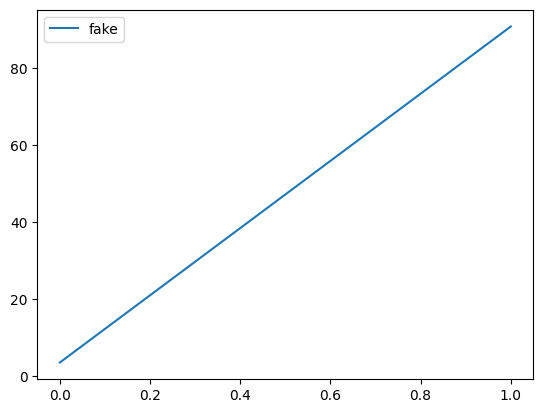

In [82]:
plot_GAN_losses(list_losses_fake)

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))

for i in range(2):
    for j in range(3):
        rand = random_G_vector_input().unsqueeze(0)

        noise = torch.cat( (rand, dataset[0][1]) , dim=1)
        fake = G_model.forward( noise ).cpu()

        # print(img.shape)
        # convert img to pil
        img = Image.fromarray((img * 255).astype(np.uint8)[0])
        # display the image
        # plt.imshow(img)
        axarr[i,j].imshow(img)#, interpolation='none', cmap='Blues'

        # TODO print comparison